In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import os
import copy
from bs4 import BeautifulSoup
import requests
import numpy as np

### Part 1: Data Scraping and Transforming

In [2]:
IMAGE_DIR='./img/'
#function for scraping images from webwites
def download_and_save(painting_url):
    r_painting_page = requests.get(painting_url)
    soup = BeautifulSoup(r_painting_page.text, 'lxml')
    for img in soup.find_all('img', {'class': 'ms-zoom-cursor'}):
        print(img)
        img_url = img['src']
        img_url = img_url.split('!')[0]
        filename = img_url.split('/')[-1]

        outfile = os.path.join(IMAGE_DIR, filename)                       
        if not os.path.exists(outfile):                        
            print("downloading {}: {}".format(filename, img_url))
            r = requests.get(img_url, outfile)
            with open(outfile, 'wb') as f:
                f.write(r.content)
        else:
            #print("skipping {}".format(filename))
            pass
    return filename
all_names=[]
#the image paths on websites, loop through to scrape
painting_paths=['https://www.wikiart.org/en/vincent-van-gogh/road-with-cypresses-1890',
                'https://www.wikiart.org/en/vincent-van-gogh/irises-1889',
                'https://www.wikiart.org/en/vincent-van-gogh/the-church-at-auvers-1890',
                'https://www.wikiart.org/en/vincent-van-gogh/summer-evening-wheatfield-with-setting-sun-1888',
               'https://www.wikiart.org/en/vincent-van-gogh/still-life-vase-with-fifteen-sunflowers-1888-1']
for path in painting_paths:
    fname=download_and_save(path)
    all_names.append(fname)

<img alt="Road with Cypresses, 1890 - Vincent van Gogh" class="ms-zoom-cursor" itemprop="image" src="https://uploads3.wikiart.org/images/vincent-van-gogh/road-with-cypresses-1890.jpg!Large.jpg" title="Road with Cypresses, 1890 - Vincent van Gogh"/>
<img alt="Irises, 1889 - Vincent van Gogh" class="ms-zoom-cursor" itemprop="image" src="https://uploads0.wikiart.org/00213/images/vincent-van-gogh/antique-3840759.jpg!Large.jpg" title="Irises, 1889 - Vincent van Gogh"/>
<img alt="The Church at Auvers, 1890 - Vincent van Gogh" class="ms-zoom-cursor" itemprop="image" src="https://uploads4.wikiart.org/images/vincent-van-gogh/the-church-at-auvers-1890.jpg!Large.jpg" title="The Church at Auvers, 1890 - Vincent van Gogh"/>
<img alt="Summer Evening, Wheatfield with Setting sun, 1888 - Vincent van Gogh" class="ms-zoom-cursor" itemprop="image" src="https://uploads8.wikiart.org/images/vincent-van-gogh/summer-evening-wheatfield-with-setting-sun-1888.jpg!Large.jpg" title="Summer Evening, Wheatfield with

In [6]:
#make a folder for debugging
if not os.path.exists('./debug/'):
     os.makedirs('./debug/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# create an input image pre-processer and scale and crop the input images
style_loader = transforms.Compose([ #for style image
    transforms.Scale((4000,5000)),
    transforms.CenterCrop(5000),
    transforms.Resize(imsize),  
    transforms.ToTensor()])  

content_loader = transforms.Compose([ #for content image
    transforms.Scale((800,1000)),
    transforms.CenterCrop(1000),
    transforms.Resize(imsize),  
    transforms.ToTensor()]) 

#funtions to load both the style and content images
def style_image_loader(image_name):
    image = Image.open(image_name)
    image = style_loader(image).unsqueeze(0)
    return image.to(device, torch.float)
def content_image_loader(image_name):
    image = Image.open(image_name)
    image = content_loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [22]:
# this cell is used for loading the specific images and make sure they have the same size
style_img = style_image_loader("./img/antique-3840759.jpg")
content_img = content_image_loader("./img/iris.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size (image set)"

style_img = style_image_loader("./img/the-church-at-auvers-1890.jpg")
content_img = content_image_loader("./img/church.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size (image set)"

style_img = style_image_loader("./img/summer-evening-wheatfield-with-setting-sun-1888.jpg")
content_img = content_image_loader("./img/wheat.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size (image set)"

style_img = style_image_loader("./img/still-life-vase-with-fifteen-sunflowers-1888-1.jpg")
original_img = content_image_loader("./img/s.jpg")
content_img = content_image_loader("./img/sunflower.png")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size (image set)"

style_img = style_image_loader("./img/road-with-cypresses-1890.jpg")
original_img = content_image_loader("./img/tree.jpg")
content_img = content_image_loader("./img/tree_deep.png")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size (image set)"


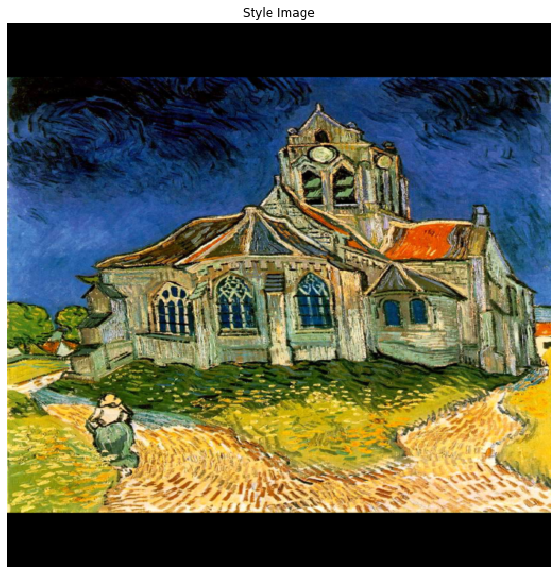

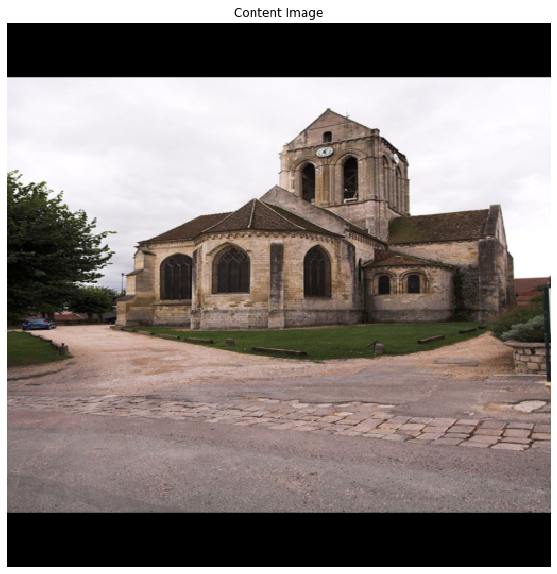

In [23]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion() # interactive mode

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

plt.figure(figsize=(10,10))
imshow(style_img, title='Style Image')

plt.figure(figsize=(10,10))
imshow(content_img, title='Content Image')

### Part 2: Style Transfer and Weight Adjusting

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg-cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 106MB/s]  


In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [14]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

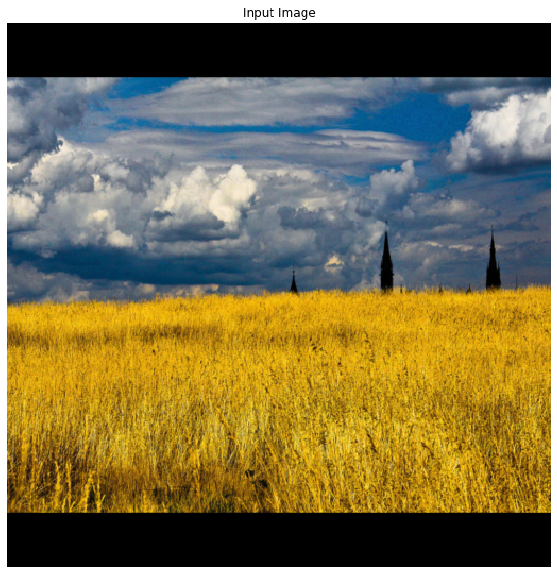

In [15]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure(figsize=(10,10))
imshow(input_img, title='Input Image')

In [16]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    #print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    #print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                #print("run {}:".format(run))
                #print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    #style_score.item(), content_score.item()))
                out_img = input_img.data.cpu().squeeze().permute(1,2,0).numpy();
                cv2.imwrite(os.path.join('debug', str(run[0]) + '.png'), out_img*255);
                #print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
#try different style weights and run the function to get the results
results=[]
for i in [5000000,1000000,500000,100000,50000,10000,5000,1]:
    input_img = content_img.clone()
    result=run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=i, content_weight=1)
    results.append(result)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [ ]:
#show all the results to choose the best one
for i in results:
    plt.figure(figsize=(8,8))
    imshow(i)

In [ ]:
#function to put all the images together in one row
def show_all(tensors,titles):
    rows = 1
    cols = len(tensors)
    axes=[]
    fig=plt.figure(figsize=(15,15))
    for i in range(rows*cols):
        img = tensors[i].cpu().clone()
        img = img.squeeze(0)
        img = unloader(img)
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=(titles[i])
        axes[-1].set_title(subplot_title)  
        plt.imshow(img)
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

In [ ]:
#give different image inputs and get the results
tensors=[content_img,style_img,results[1]]
titles=['original/content','style','result']
show_all(tensors,titles)

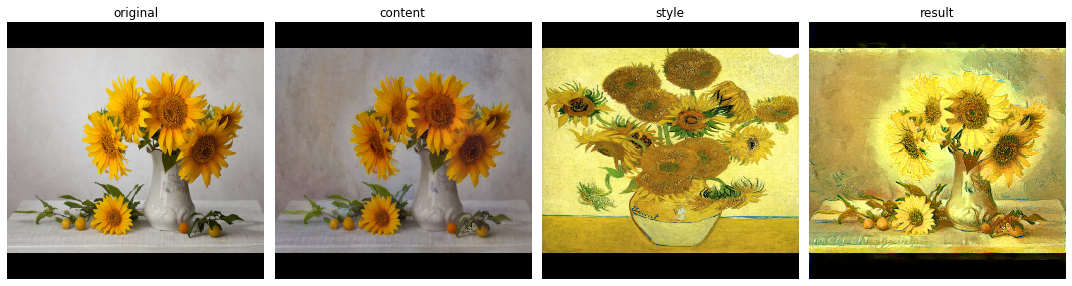

In [20]:
show_all(tensors_sun,titles_sun)